In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

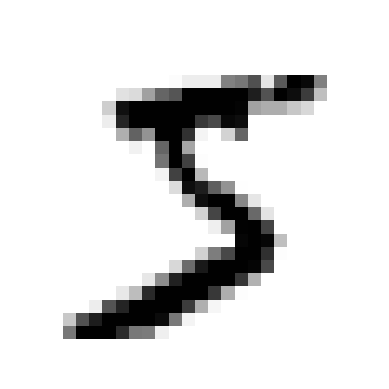

In [5]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt


mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

# Select the first digit
some_digit = X.iloc[0]  
some_digit_image = some_digit.values.reshape(28, 28)  

# Plot the digit
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

In [7]:
import numpy as np
y = y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 1.Training a Binary Classifier :
### is able to disiguish between just tow calsses 5 and not 5

In [9]:
y_train_5 = (y_train == 5) 
# True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

# Stochastic Gradient Descent (SGD) Classifier

## Using Scikit-Learn’s SGDClassifier Class
- Efficiently handles very large datasets.
- Trains instances independently, one at a time (suitable for online learning).

## Note:
- The SGDClassifier relies on randomness during training (hence the name “stochastic”).
- For reproducible results, set the `random_state` parameter.

In [10]:
from sklearn.linear_model import SGDClassifier 
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

<span style="color:#f2e86d; font-weight: bold; font-size: 24px;">2.performance measures</span>

<span style="color:pink; font-weight: bold; font-size: 16px;">2.a Measuring Accuracy Using Cross-Validation</span>


In [12]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone  
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf) 
  X_train_folds = X_train.iloc[train_index] 
  y_train_folds = y_train_5.iloc[train_index] 
  X_test_fold = X_train.iloc[test_index] 
  y_test_fold = y_train_5.iloc[test_index]  
  clone_clf.fit(X_train_folds, y_train_folds) 
  y_pred = clone_clf.predict(X_test_fold) 
  n_correct = sum(y_pred == y_test_fold)  
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


Let’s use the cross_val_score() it returns the accurency of each fold 


In [13]:
from sklearn.model_selection import cross_val_score  
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.base import BaseEstimator  
class Never5Classifier(BaseEstimator):
     def fit(self, X, y=None): 
         return self  
     def predict(self, X): 
         return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier() 
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

<span style="font-size: 14px; color:pink;">
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets 
</span>


<span style="color:pink; font-weight: bold; font-size: 16px;">2b.Confusion Matrix</span>

In [16]:
from sklearn.model_selection import cross_val_predict

# Perform cross-validation predictions
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [17]:
from sklearn.metrics import confusion_matrix 
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:

y_train_perfect_predictions = y_train_5 # pretend we reached perfection 
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)


<span style="color:pink; font-weight: bold; font-size: 16px;">2c.RECALL & PRECISION</span>


In [19]:
from sklearn.metrics import precision_score, recall_score  
precision_score(y_train_5, y_train_pred) 

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311


<span style="color:pink; font-weight: bold; font-size: 16px;">NB:F1 SCORE combine the precion and recall its the harmonic mean f precion and recall</span>



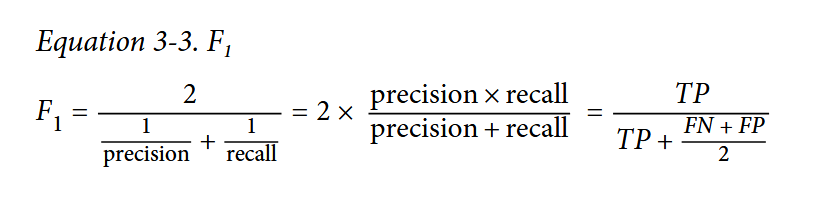


In [21]:
from sklearn.metrics import f1_score 
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [22]:
y_scores = sgd_clf.decision_function([some_digit]) 
y_scores

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [24]:
threshold = 8000 
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

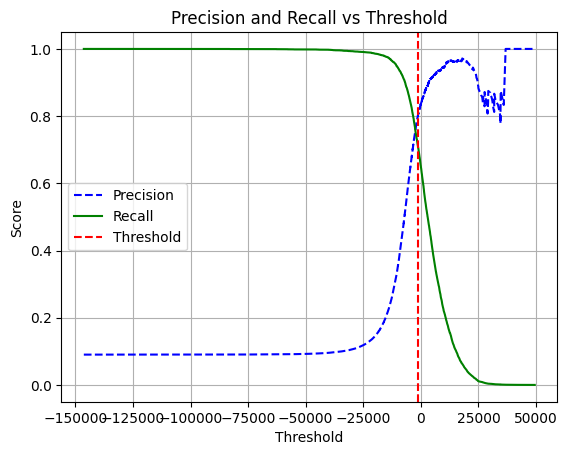

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
     plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
     plt.plot(thresholds, recalls[:-1], "g-", label="Recall")  
     plt.xlabel("Threshold")
     plt.ylabel("Score")
     plt.title("Precision and Recall vs Threshold")
     plt.legend(loc="best")
     plt.grid(True)
     plt.axvline(x=thresholds[np.argmax(precisions[:-1] >= 0.8)], color='r', linestyle='--', label='Threshold')
     plt.legend(loc="best")

# Example usage:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

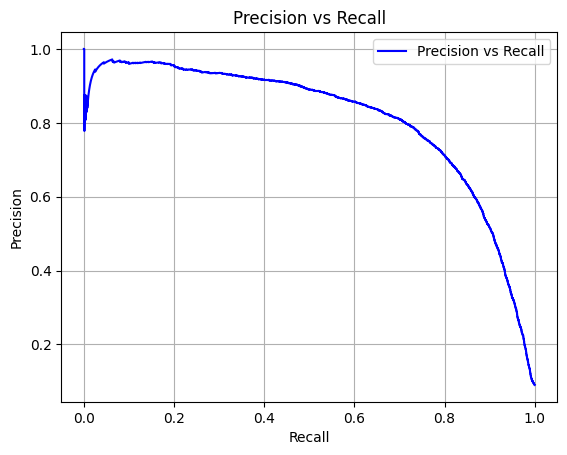

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", label="Precision vs Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision vs Recall")
    plt.legend(loc="best")
    plt.grid(True)


plot_precision_vs_recall(precisions, recalls)
plt.show()

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [33]:
from sklearn.metrics import roc_curve 
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

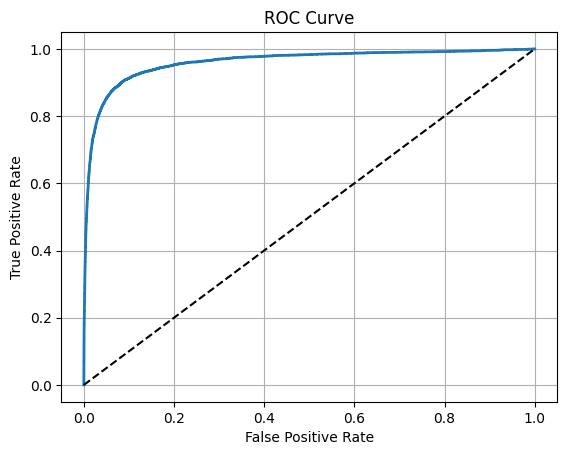

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
     plt.plot(fpr, tpr, linewidth=2, label=label) 
     plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal [...] 
     plt.xlabel('False Positive Rate')
     plt.ylabel('True Positive Rate')
     plt.title('ROC Curve')
     plt.grid(True)
plot_roc_curve(fpr, tpr) 
plt.show()

training RandomForestClassifier

In [35]:
from sklearn.ensemble import RandomForestClassifier  
forest_clf = RandomForestClassifier(random_state=42) 
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [36]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

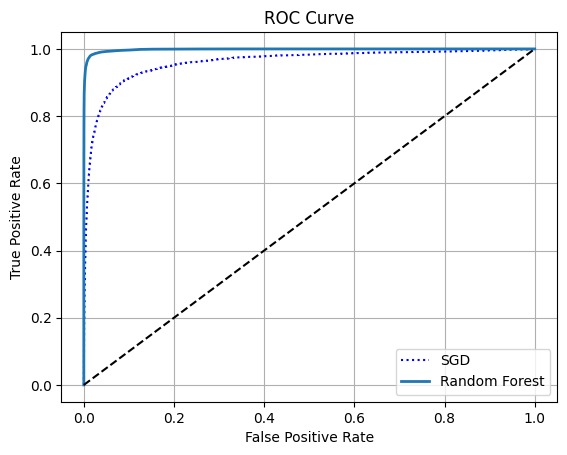

In [37]:
plt.plot(fpr, tpr, "b:", label="SGD") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend(loc="lower right") 
plt.show()

In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145